# Test EEG-DBS Synchronisation of EPI Data

In [1]:
import numpy as np
import pandas as pd
import sys

sys.path.append(r"C:\Users\slena\Repos\ngb_study\EEG\Python")
from pathlib import Path
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

from scipy.ndimage import uniform_filter1d

from scipy.signal import butter, filtfilt, iirnotch, spectrogram, welch, hilbert
import json
# EEG packages
import mne
# print current working directory
import os
print(os.getcwd())

# go one step back in the directory
os.chdir("..")
print(os.getcwd())

def load_json_file(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data


/Users/lenasalzmann/dev/dbs-eeg-sync/notebooks
/Users/lenasalzmann/dev/dbs-eeg-sync


In [2]:
# import local modules
from dbs_eeg_sync import data_loader
from dbs_eeg_sync.power_calculator import  compute_samplewise_eeg_power
from dbs_eeg_sync.sync_artifact_finder import detect_eeg_sync_artifact, detect_dbs_sync_artifact
from dbs_eeg_sync.plotting import apply_publication_style, EEG_COLOR, DBS_COLOR


In [3]:
# load eeg data
file_path = "/Volumes/green_groups_re_public/RELab/Data_confidential/StimuLOOP_Neurofeedback/eeg_dbs_sync_epi/eeg_epi_pat1_raw.fif"
eeg_raw = mne.io.read_raw_fif(file_path, preload=True)

Opening raw data file /Volumes/green_groups_re_public/RELab/Data_confidential/StimuLOOP_Neurofeedback/eeg_dbs_sync_epi/eeg_epi_pat1_raw.fif...
Isotrak not found
    Range : 0 ... 406327 =      0.000 ...  1587.215 secs
Ready.
Reading 0 ... 406327  =      0.000 ...  1587.215 secs...


In [4]:
# read json file
json_file = Path(r"/Volumes/green_groups_re_public/RELab/Data_confidential/StimuLOOP_Neurofeedback/eeg_dbs_sync_epi/Report_Json_Session_Report_20250714T125042_pat1.json")
json_data = data_loader.open_json_file(json_file)

In [5]:
# length of DBS LFP data
for i in range(len(json_data["BrainSenseLfp"])):
    print(i, '   ' , len(json_data["BrainSenseLfp"][i]["LfpData"])/2, '   ' , len(json_data["BrainSenseLfp"][i]["LfpData"])/2/60
          )

0     85.0     1.4166666666666667


In [6]:
# get time domain data from json file
recording_number = 0
time_domain_data = data_loader.read_time_domain_data(json_data, 0)

Compute EEG power

In [7]:
eeg_raw.info['sfreq']

256.0

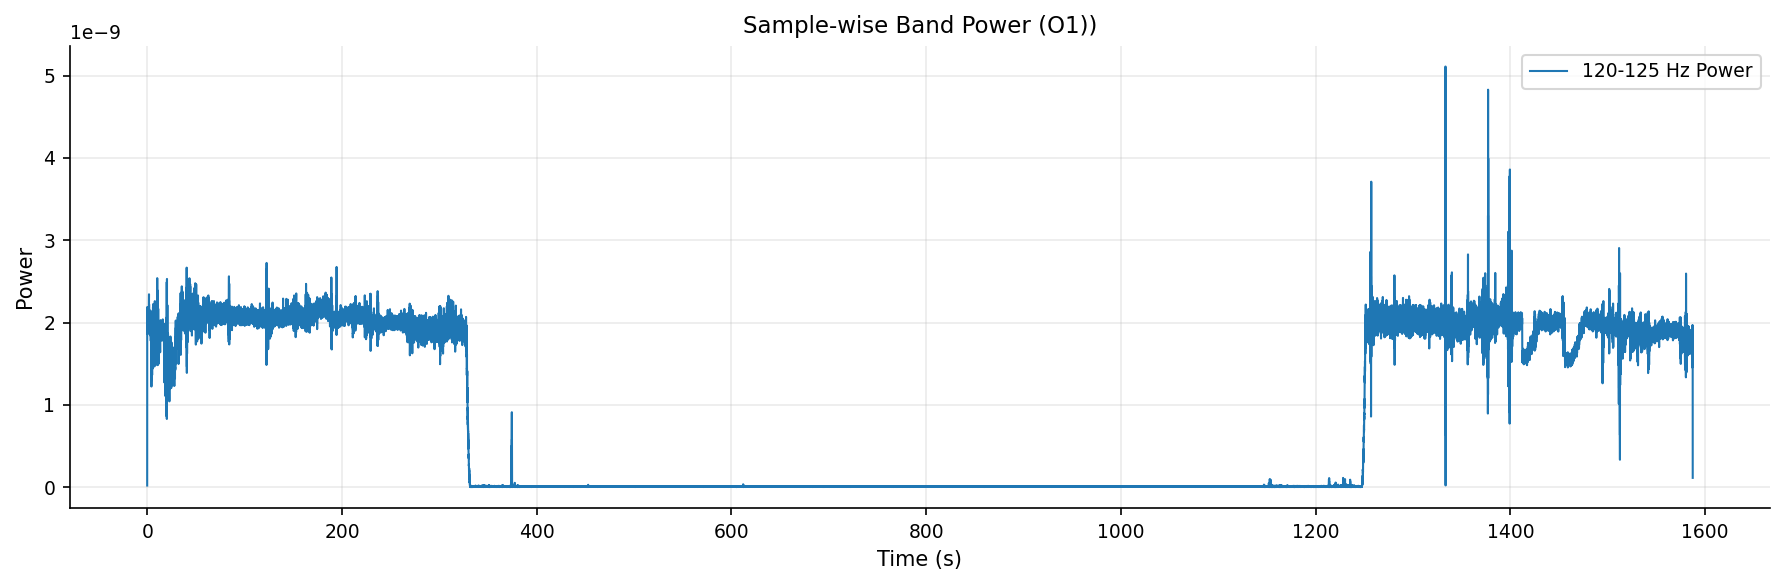

In [8]:
eeg_power, time_axis = compute_samplewise_eeg_power(eeg_raw, 120, 125, channel='O1', plot=True)

In [9]:
# add 2 synchronisation events to eeg data
sync1_sec = 1408.7461
sync2_sec = 1453.668

# Define sync event onsets and descriptions
onsets = [sync1_sec, sync2_sec]  # in seconds
durations = [0, 0]  # 0 duration = point event
descriptions = ['sync1', 'sync2']

# Create and add annotations
annotations = mne.Annotations(onset=onsets, duration=durations, description=descriptions)
eeg_raw.set_annotations(annotations)


<Raw | eeg_epi_pat1_raw.fif, 41 x 406328 (1587.2 s), ~127.1 MiB, data loaded>

In [10]:
# Convert annotations to events
events, event_id = mne.events_from_annotations(eeg_raw)

# Define epochs around each event
tmin = -1.0  # 1 sec before event
tmax = 1.0   # 2 sec after event

epochs = mne.Epochs(eeg_raw, events=events, event_id=event_id,
                    tmin=tmin, tmax=tmax, baseline=(None, 0), preload=True)

Used Annotations descriptions: [np.str_('sync1'), np.str_('sync2')]
Not setting metadata
2 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 2 events and 513 original time points ...
0 bad epochs dropped


Plotting epoch for: sync1
Using matplotlib as 2D backend.


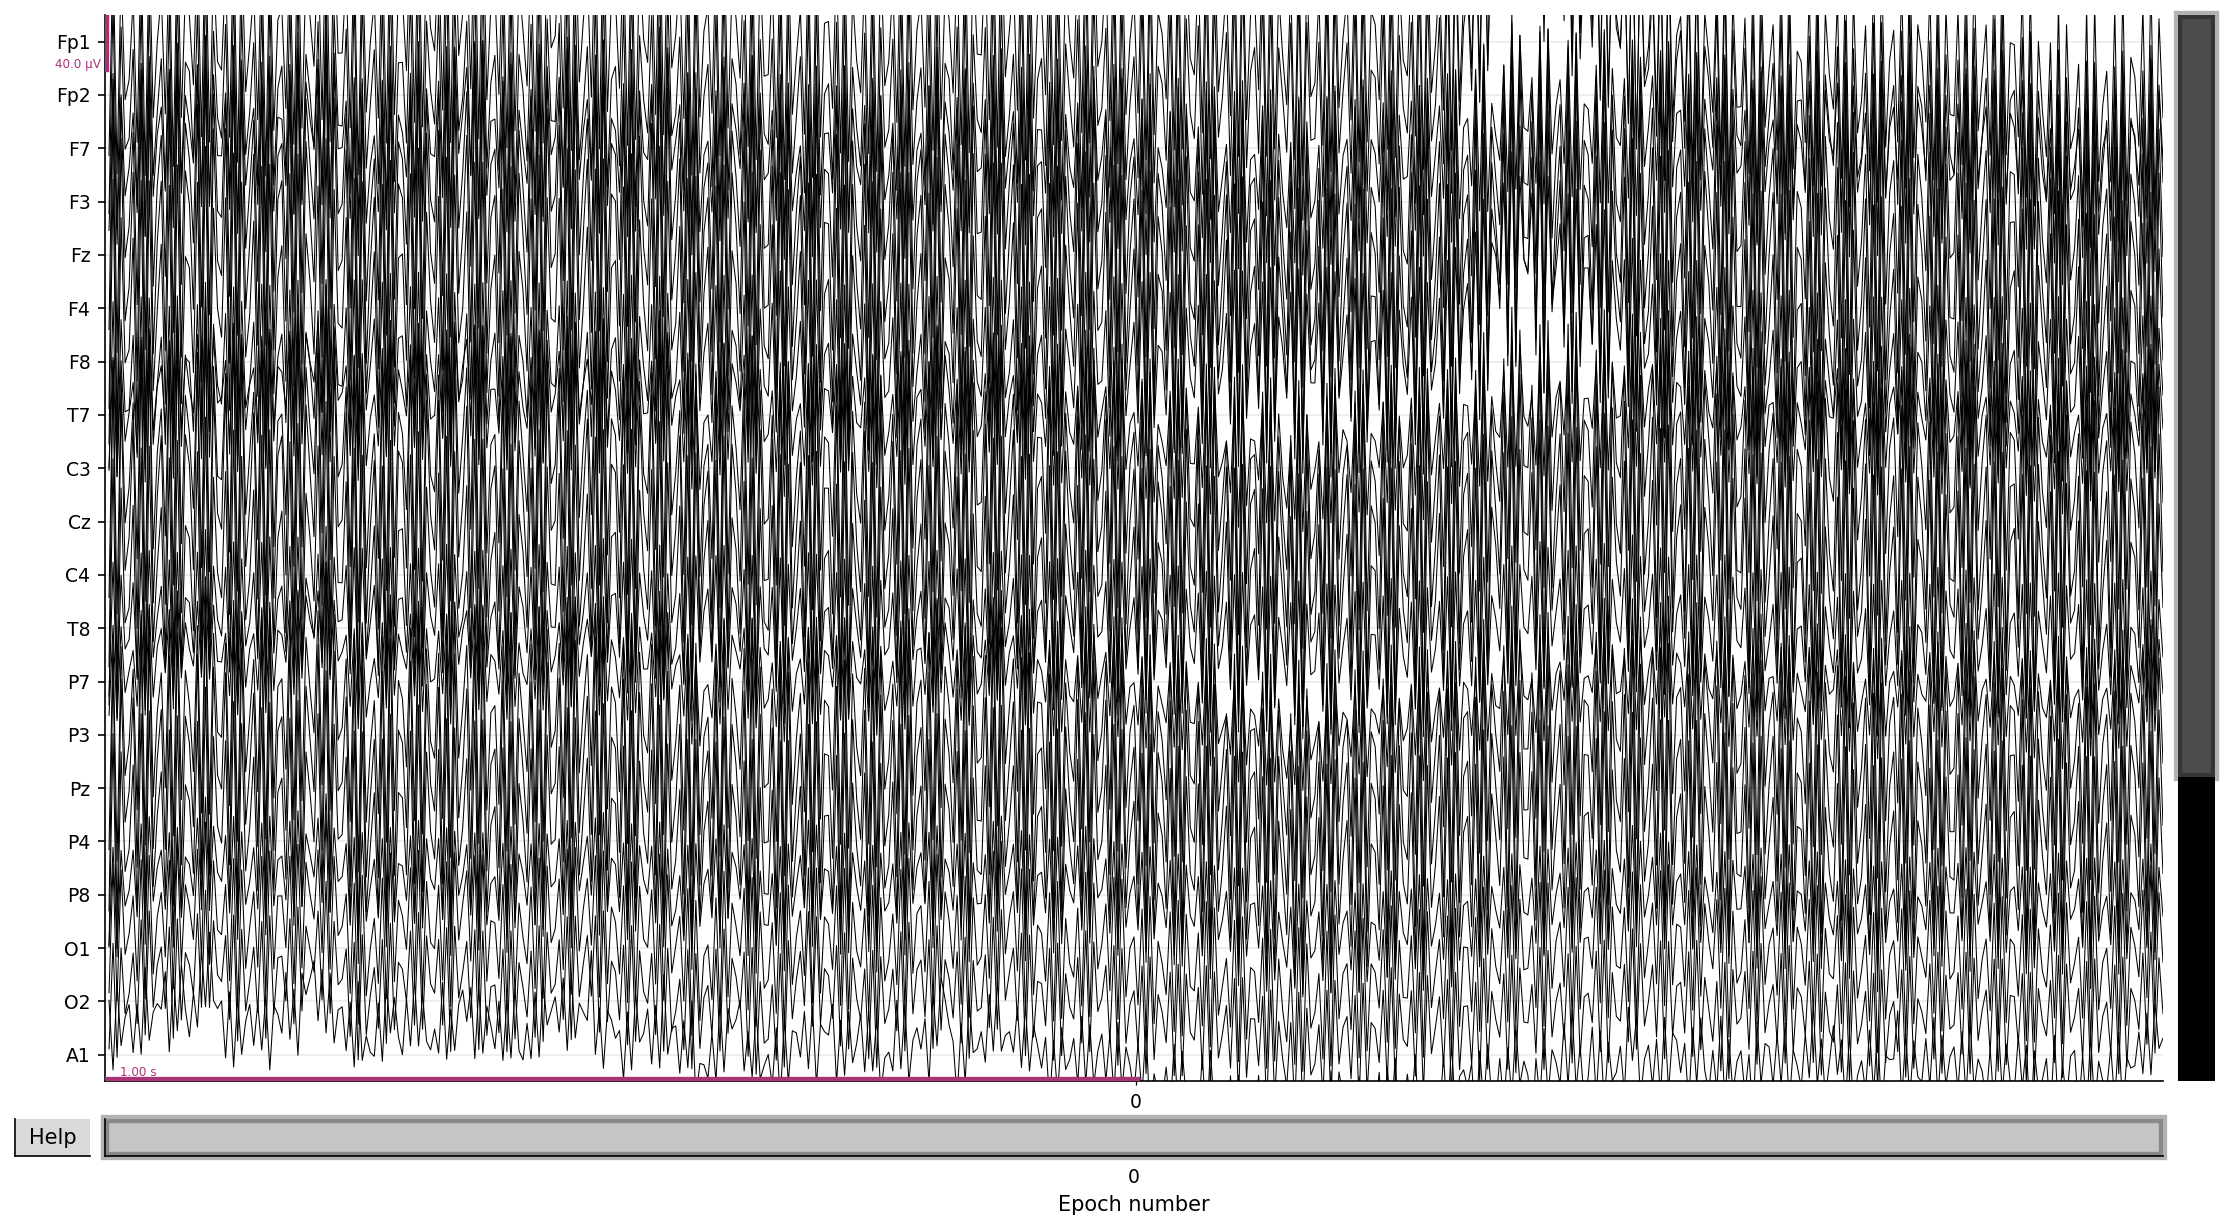

Plotting epoch for: sync2


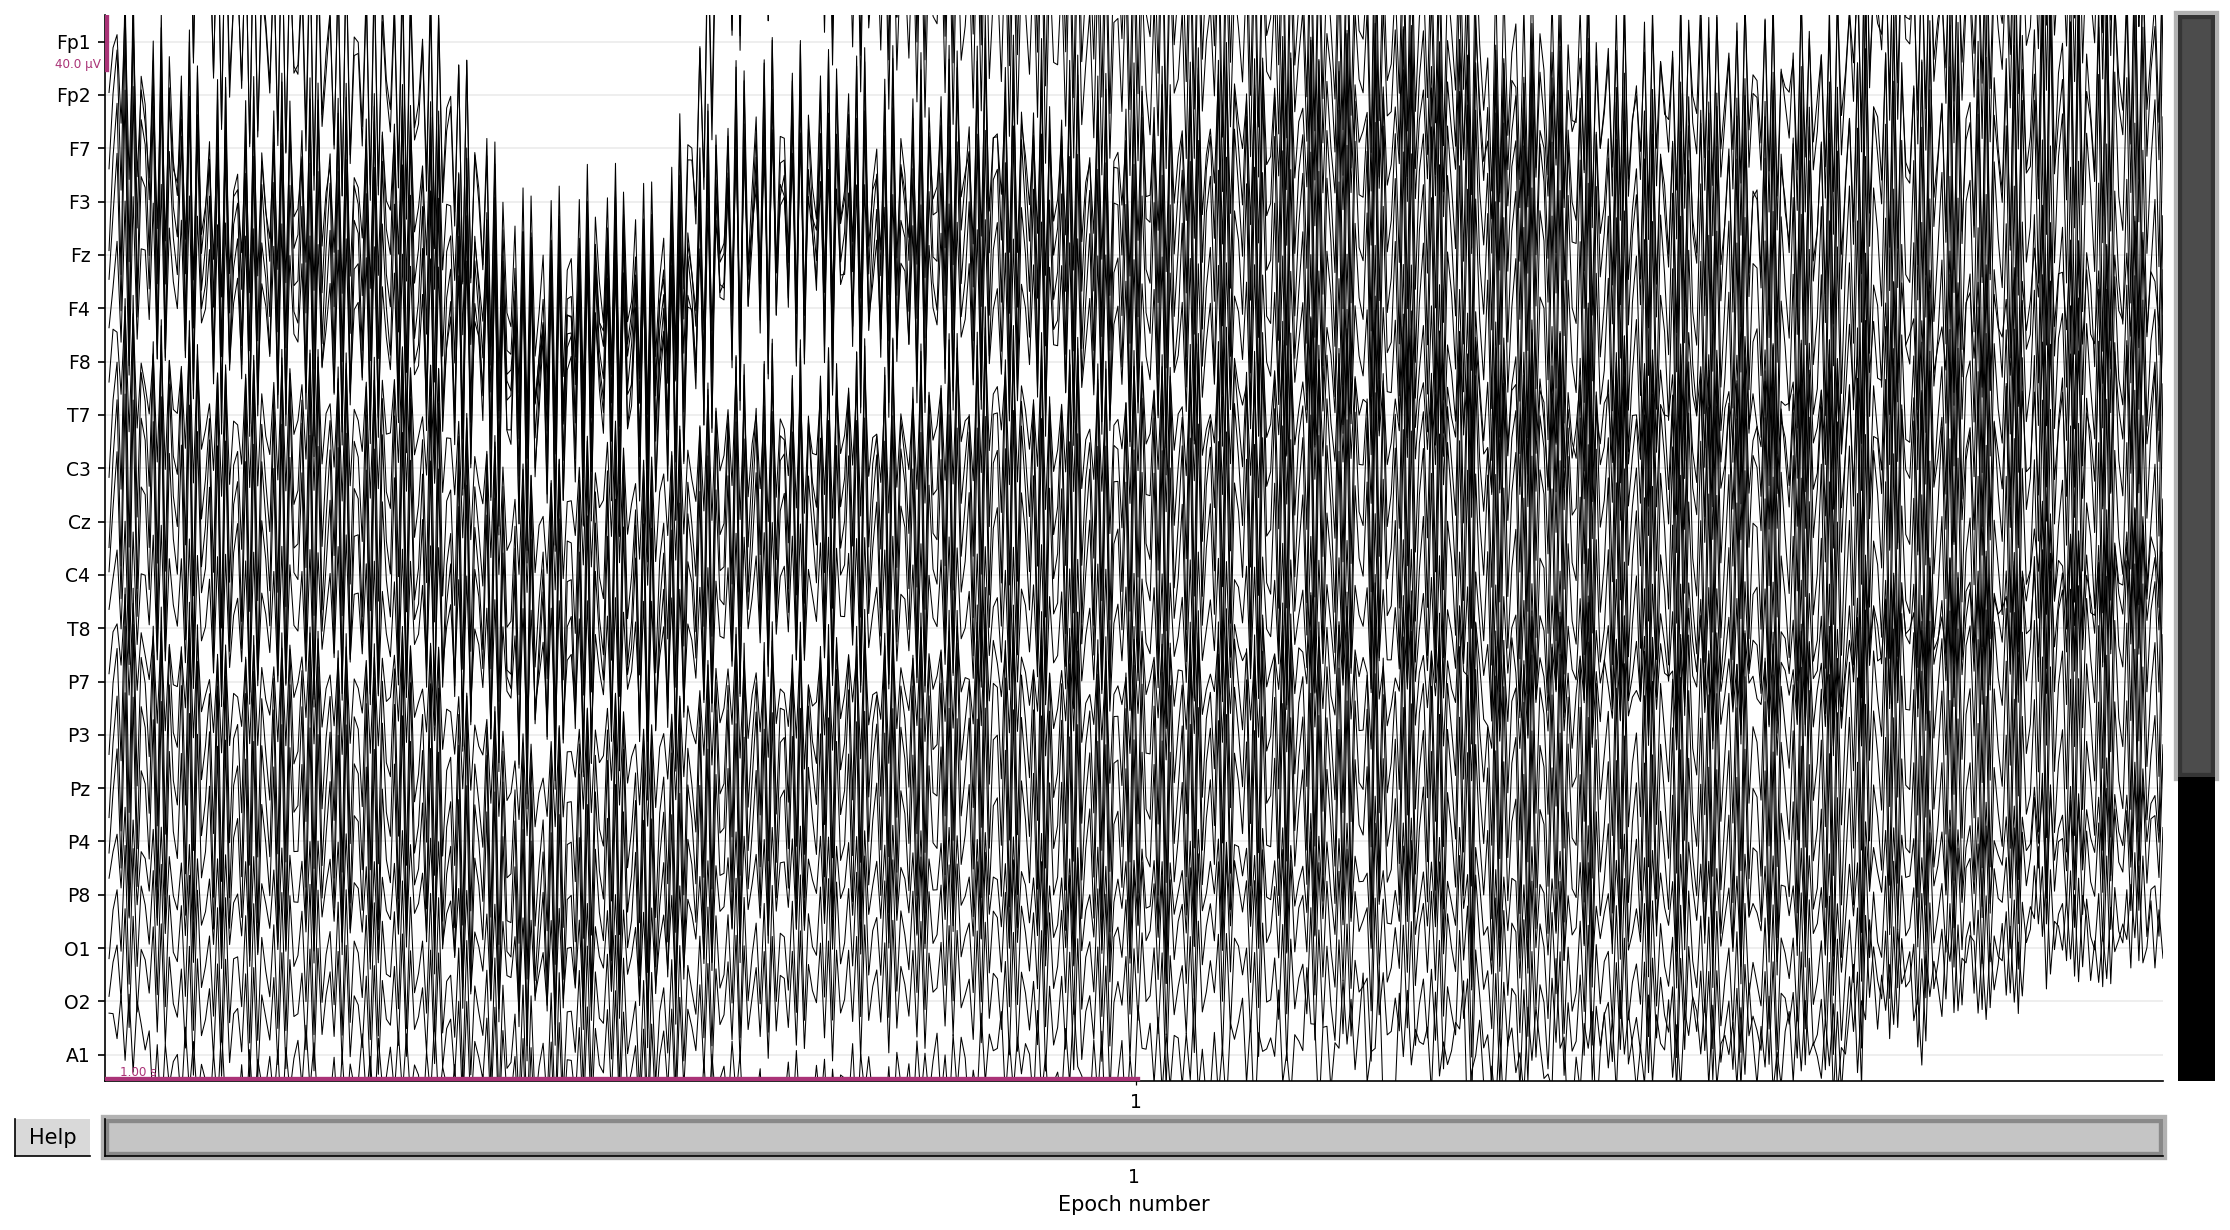

In [11]:
# plot data around sync1 and sync2
event_names = list(event_id.keys())  # ['sync1', 'sync2']
for name in event_names:
    print(f"Plotting epoch for: {name}")
    epoch = epochs[name]  # returns an Epochs object for this event
    epoch.plot(n_epochs=1, title=f"EEG around {name}");

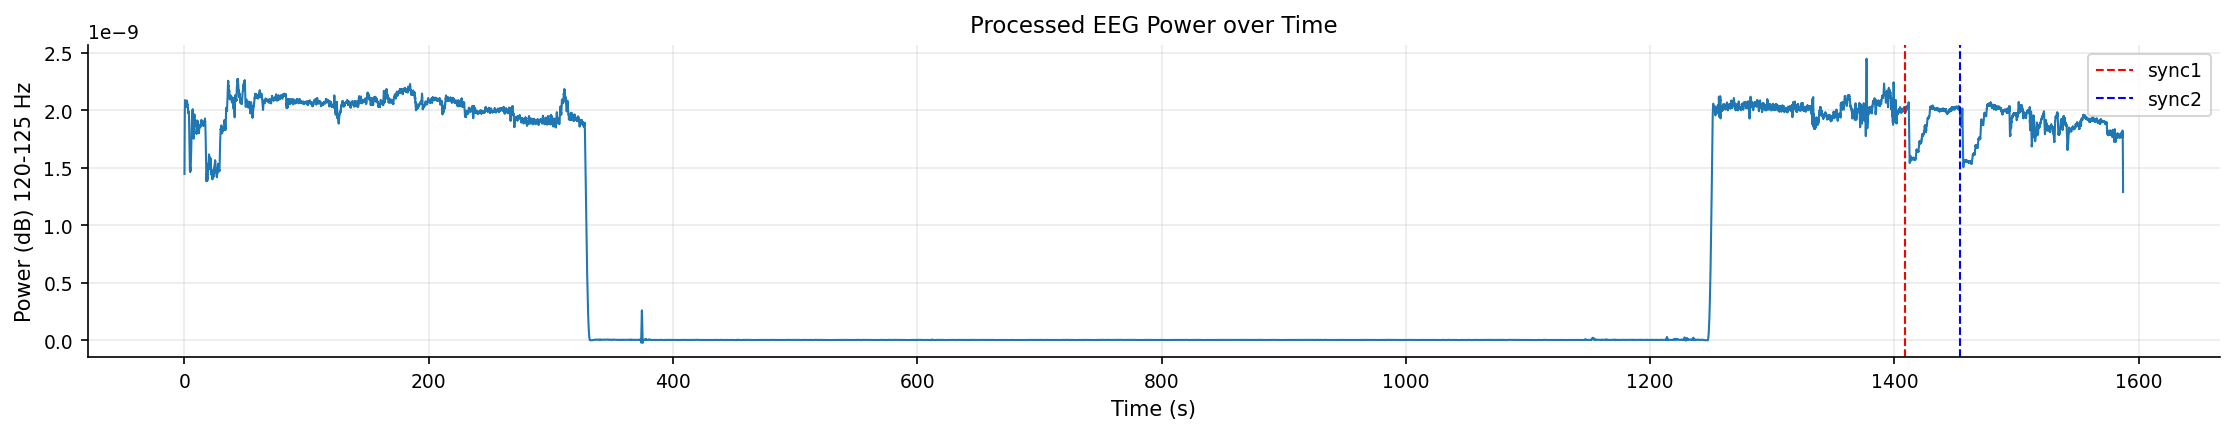

In [12]:
# plot eeg_power over time_axis between 1350 and 1500 s

plt.figure(figsize=(15, 3))
plt.plot(time_axis, eeg_power)
# x-axis label
plt.xlabel('Time (s)')
# y-axis label
plt.ylabel('Power (dB) 120-125 Hz')
# title
plt.title('Processed EEG Power over Time')
# add vertical lines at sync1 and sync2
plt.axvline(x=sync1_sec, color='r', linestyle='--', label='sync1')
plt.axvline(x=sync2_sec, color='b', linestyle='--', label='sync2')
plt.legend()
plt.show()


## Automatic detection of artifact

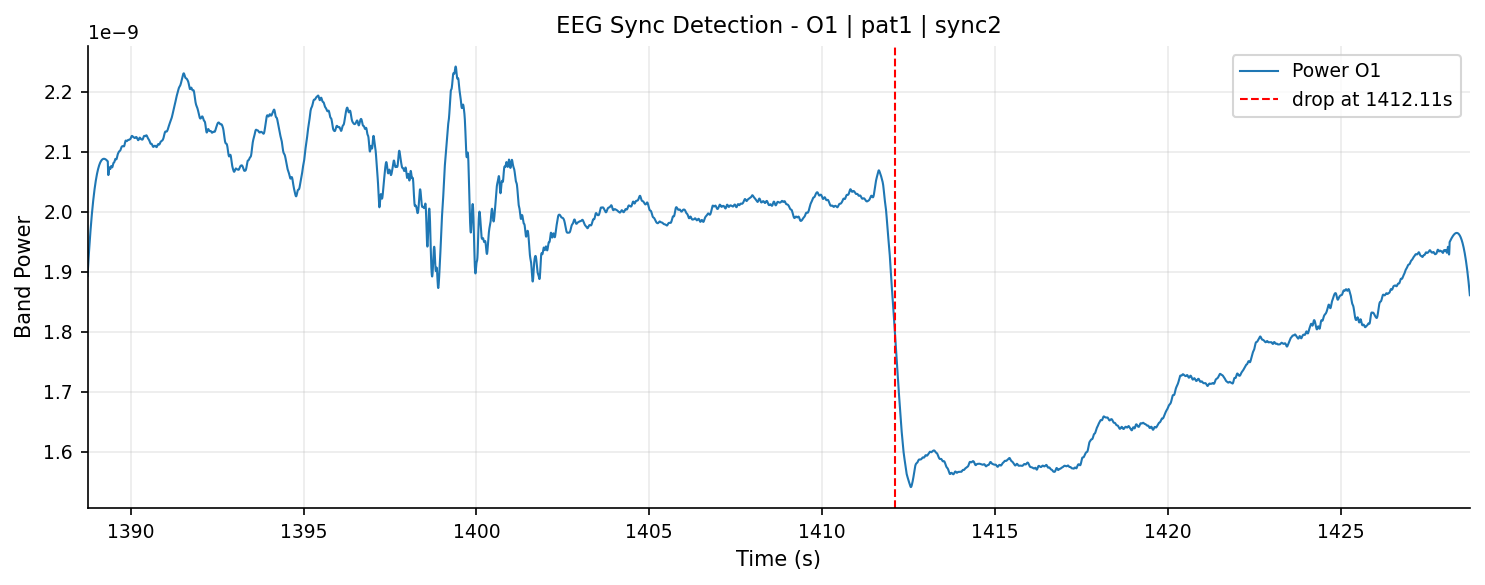

Sync 1 detected at 1412.1132875s or 361501 samples


In [13]:
# 
best_channel, eeg_sync_idx, eeg_sync_s, best_result,  power = detect_eeg_sync_artifact(eeg_raw, freq_low=120, freq_high=125, time_range=(sync1_sec-20, sync1_sec+20), channel_list=['O1'], plot=True, save_dir=None, sub_id='pat1', block='sync2')
print(f'Sync 1 detected at {eeg_sync_s}s or {eeg_sync_idx} samples')

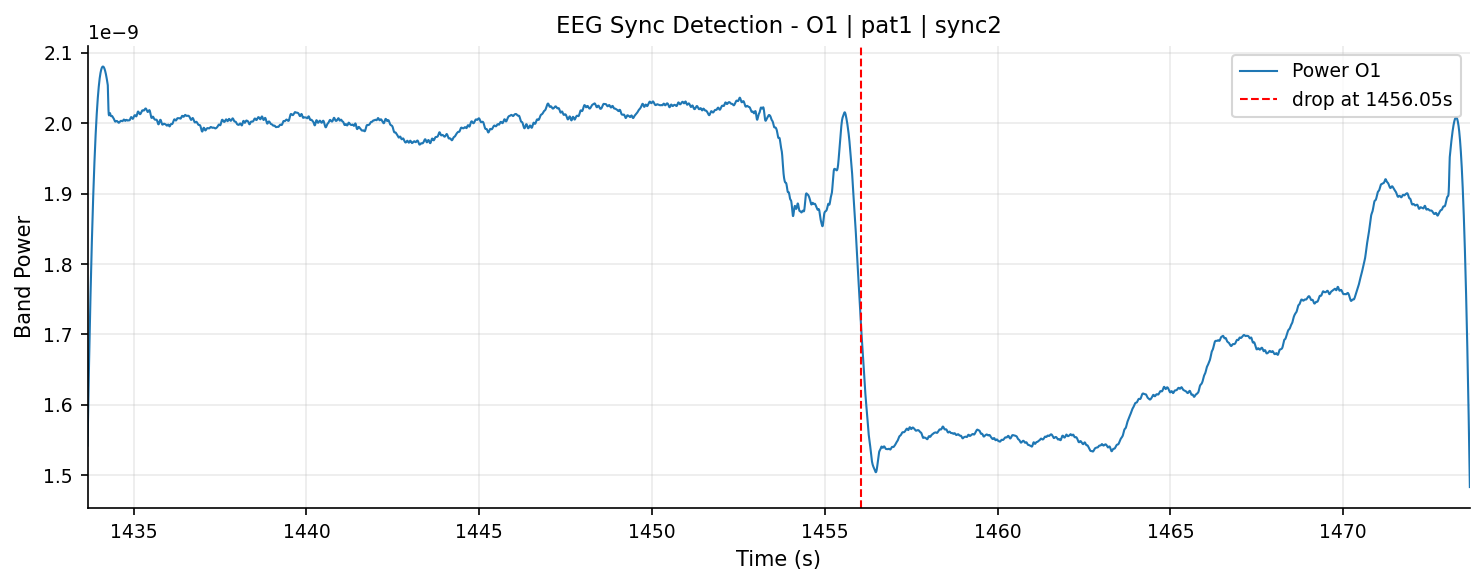

Sync 2 detected at 1456.04690625s or 372748 samples


In [14]:
best_channel, eeg_sync_idx, eeg_sync_s, best_result,  power = detect_eeg_sync_artifact(eeg_raw, freq_low=120, freq_high=125, time_range=(sync2_sec-20, sync2_sec+20), channel_list=['O1'], plot=True, save_dir=None, sub_id='pat1', block='sync2')
print(f'Sync 2 detected at {eeg_sync_s}s or {eeg_sync_idx} samples')

## Publication Plot: figure 2

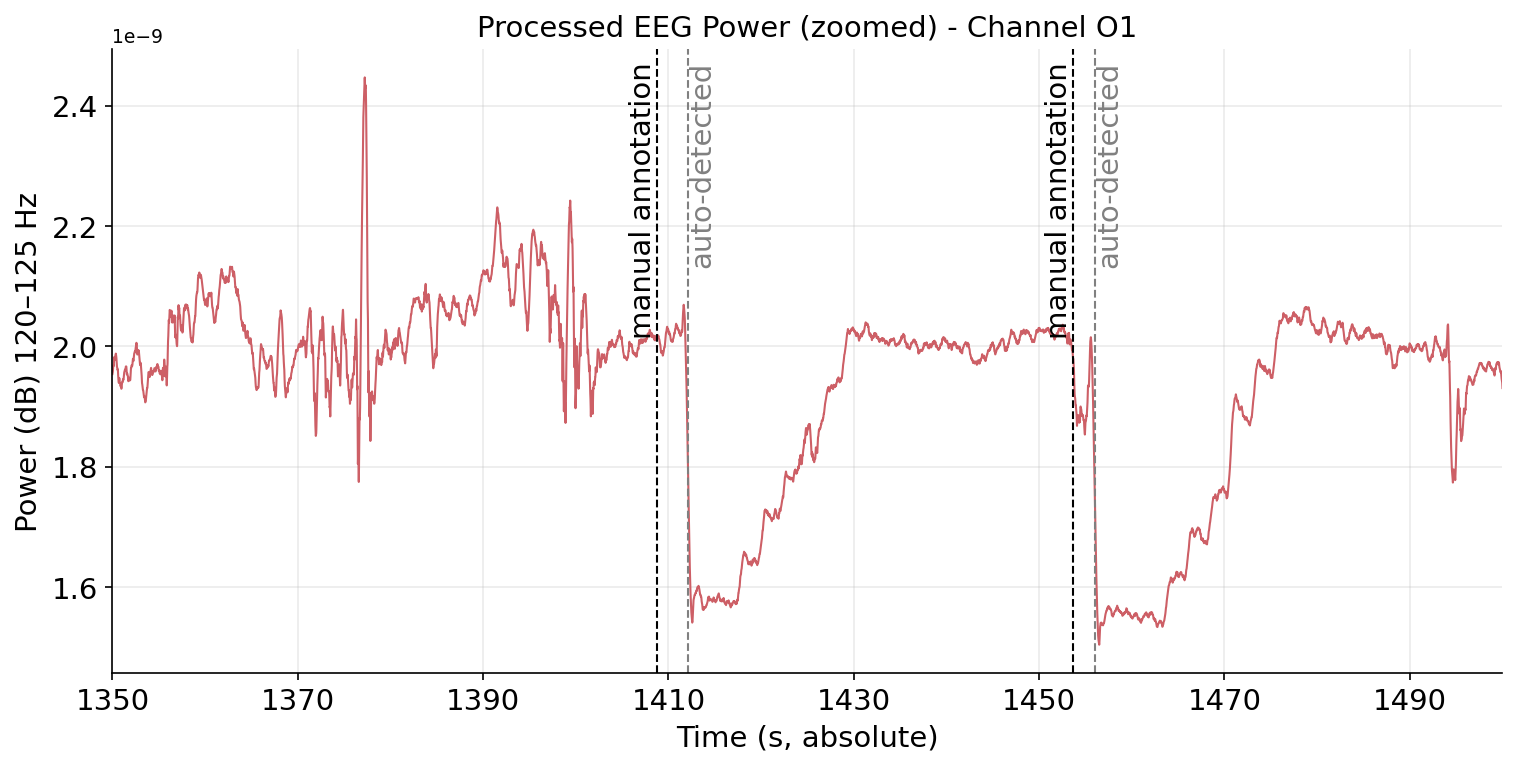

In [25]:
# --- given ---
sync1_sec = 1408.7461
sync2_sec = 1453.668
t = time_axis
p = eeg_power

sync1_detected_org = 361502
sync2_detected_org = 372747
sync1_detected_sec = float(t[sync1_detected_org])
sync2_detected_sec = float(t[sync2_detected_org])

t0, t1 = 1350.0, 1500.0
offset = t0
m = (t >= t0) & (t <= t1)

fig, ax = plt.subplots(figsize=(10, 5), constrained_layout=True)

ax.plot(t[m] - offset, p[m], color=EEG_COLOR, label='EEG Power (120–125 Hz)')

# helper to place label inside axes without expanding layout:
def vline_with_label(x_abs, label, color, ha):
    x = x_abs - offset
    ax.axvline(x, color=color, ls='--', zorder=2)
    ax.text(x, 0.98, label, color=color, rotation=90, va='top', ha=ha,
            transform=ax.get_xaxis_transform(), clip_on=True, fontsize=14)

# manual (grey)
for s in (sync1_sec, sync2_sec):
    vline_with_label(s, "manual annotation", "black", ha='right')

# auto-detected (black)
for s in (sync1_detected_sec, sync2_detected_sec):
    vline_with_label(s, "auto-detected", "grey", ha='left')

# absolute seconds on ticks while plotting offset data
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{x + offset:.0f}"))
ax.set_xlim(0, t1 - t0)
ax.set_xlabel("Time (s, absolute)", fontsize=14)
ax.set_ylabel("Power (dB) 120–125 Hz", fontsize=14)
ax.set_title("Processed EEG Power (zoomed) - Channel O1", fontsize=14)
# ax.legend(loc='upper left', frameon=False, fontsize=14)

# tick label size
ax.tick_params(axis='both', which='major', labelsize=14)

# save figure
plt.savefig("notebooks/outputs/plots/fig2_validation_manual_vs_auto_sync.pdf")
plt.show()

# Read Pat 2

In [16]:
# read eeg_epi_pat2_raw.fif
path = r"/Volumes/green_groups_re_public/RELab/Data_confidential/StimuLOOP_Neurofeedback/eeg_dbs_sync_epi/eeg_epi_pat2_raw.fif"
eeg_raw_pat2 = mne.io.read_raw_fif(path, preload=True)

Opening raw data file /Volumes/green_groups_re_public/RELab/Data_confidential/StimuLOOP_Neurofeedback/eeg_dbs_sync_epi/eeg_epi_pat2_raw.fif...
Isotrak not found
    Range : 0 ... 333711 =      0.000 ...  1303.559 secs
Ready.
Reading 0 ... 333711  =      0.000 ...  1303.559 secs...


In [17]:
# check length of eeg_raw
len(eeg_raw_pat2)
# print length in seconds
print(f'length of eeg_raw: {len(eeg_raw_pat2) / eeg_raw_pat2.info['sfreq']} seconds')
# print number of channels
print(f'number of channels: {eeg_raw_pat2.info['nchan']}')
# print sampling rate
print(f'sampling rate: {eeg_raw_pat2.info['sfreq']} Hz')

length of eeg_raw: 1303.5625 seconds
number of channels: 41
sampling rate: 256.0 Hz


Used Annotations descriptions: [np.str_('1 Hz'), np.str_('10 Hz'), np.str_('15 Hz'), np.str_('18 Hz'), np.str_('2 Hz'), np.str_('20 Hz'), np.str_('25 Hz'), np.str_('40 Hz'), np.str_('50 Hz'), np.str_('60 Hz'), np.str_('8 Hz'), np.str_('<Event: DBS umgestellt'), np.str_('Augen Auf'), np.str_('Augen Zu'), np.str_('DBS aktiviert'), np.str_('DBS umgestellt'), np.str_('DBS wieder auf Gruppe A umgestellt'), np.str_('Doktorantin'), np.str_('Elektroden getestet CZ'), np.str_('Fix Elektr.'), np.str_('HV 120 sec'), np.str_('HV 150 sec'), np.str_('HV 30 sec'), np.str_('HV 60 sec'), np.str_('HV 90 sec'), np.str_('HV Anfang'), np.str_('HV Ende'), np.str_('Pat spricht'), np.str_('Post HV 120 sec'), np.str_('Post HV 150 sec'), np.str_('Post HV 30 sec'), np.str_('Post HV 60 sec'), np.str_('Post HV 90 sec'), np.str_('Synchronizierung'), np.str_('lacht')]


/var/folders/1_/cvx_3yt96s7gxzrkn4b55xlc0000gn/T/ipykernel_4959/2371757676.py:3: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.
  mne.viz.plot_events(events=all_events, event_id=all_event_id, sfreq=eeg_raw_pat2.info["sfreq"]);


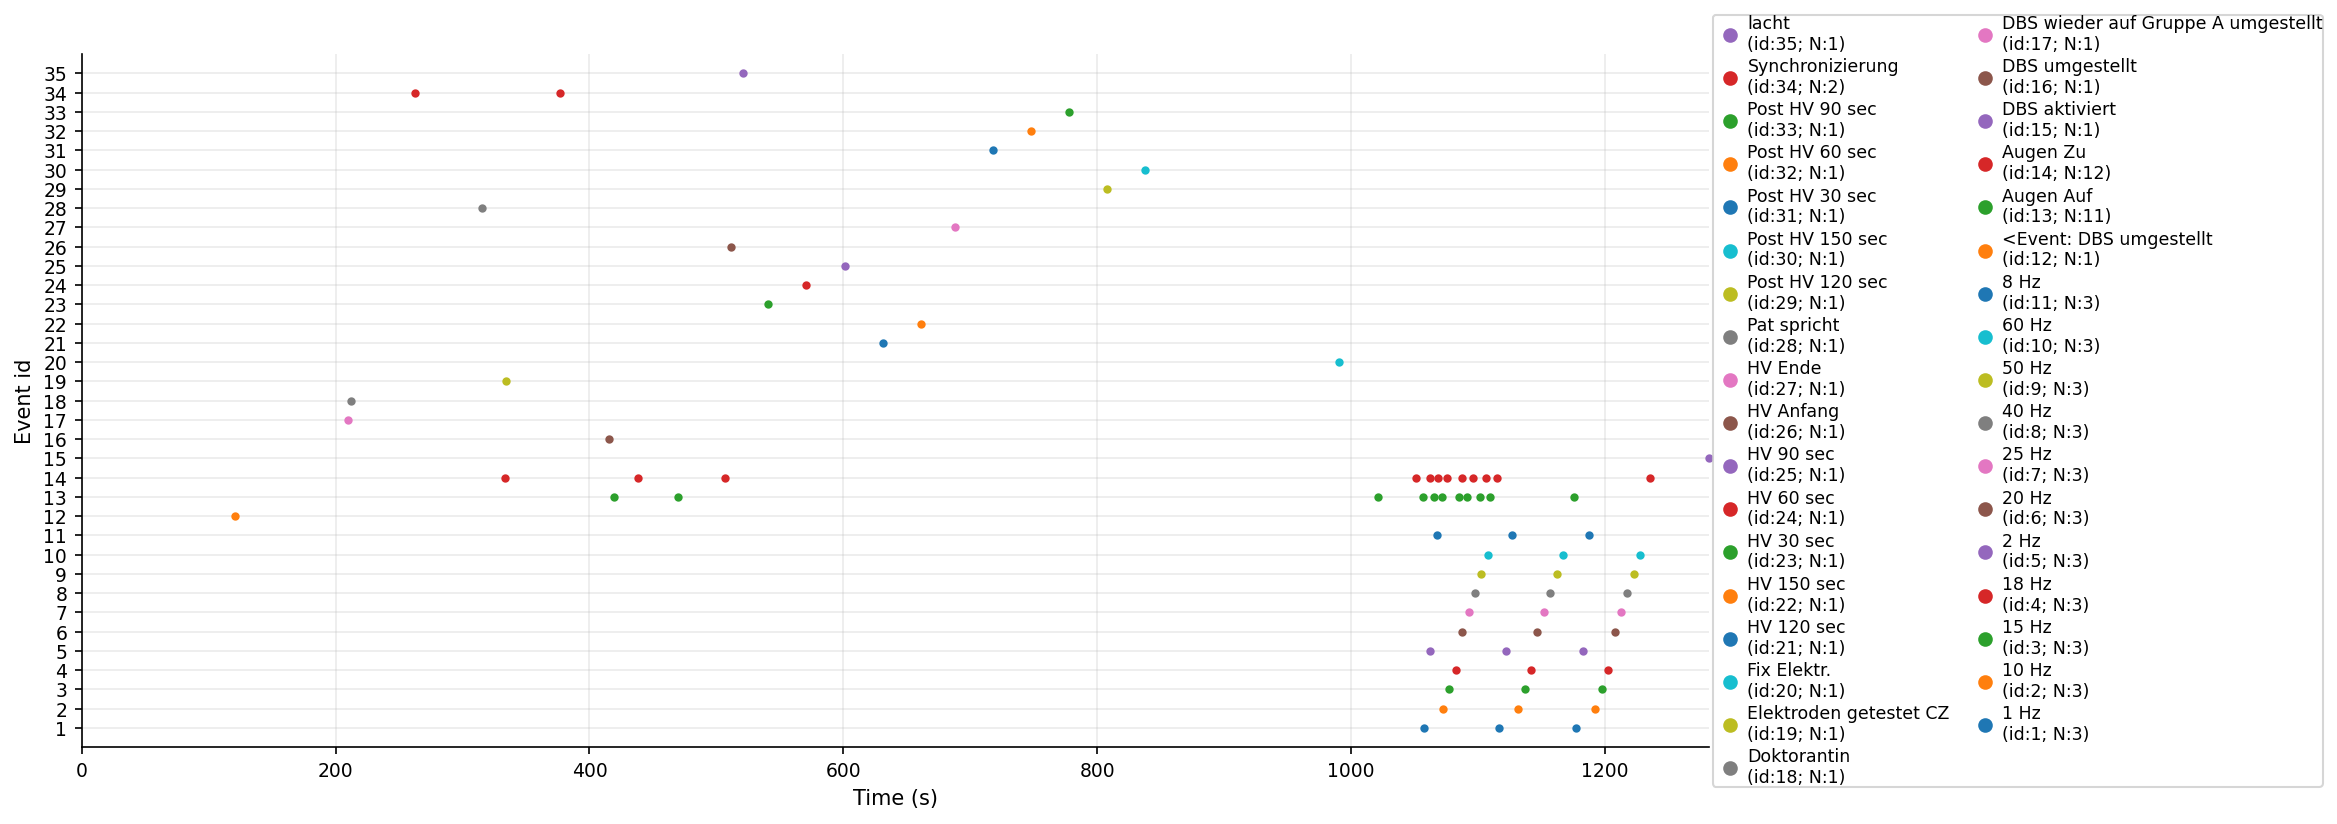

In [18]:
# investigate eeg_raw annotations
all_events, all_event_id = mne.events_from_annotations(eeg_raw_pat2)
mne.viz.plot_events(events=all_events, event_id=all_event_id, sfreq=eeg_raw_pat2.info["sfreq"]);

In [19]:
# get the time stamp of the following events:
#  np.str_('Doktorantin'): 18,
#  np.str_('Elektroden getestet CZ'): 19,
#  np.str_('Synchronizierung'): 34,

# Your target events
target_events = ["Doktorantin", "Elektroden getestet CZ", "Synchronizierung"]

# Get their IDs from the mapping
target_ids = [all_event_id[np.str_(ev)] for ev in target_events]

# Filter events that match those IDs
mask = np.isin(all_events[:, 2], target_ids)
selected_events = all_events[mask]

sfreq = eeg_raw_pat2.info['sfreq']
timestamps_sec = selected_events[:, 0] / sfreq

for ev, idx, ts in zip(selected_events[:, 2], selected_events[:, 0], timestamps_sec):
    name = [k for k, v in all_event_id.items() if v == ev][0]
    print(f"{name:25s} at sample {idx} → {ts:.2f} sec")

Doktorantin               at sample 54240 → 211.88 sec
Synchronizierung          at sample 67265 → 262.75 sec
Elektroden getestet CZ    at sample 85497 → 333.97 sec
Synchronizierung          at sample 96471 → 376.84 sec


In [20]:
# add synchronisation events to eeg data
sync1_sec = 262.75
sync2_sec = 376.84

# Define sync event onsets and descriptions
onsets = [sync1_sec, sync2_sec]  # in seconds
durations = [0, 0]  # 0 duration = point event
descriptions = ['sync1', 'sync2']

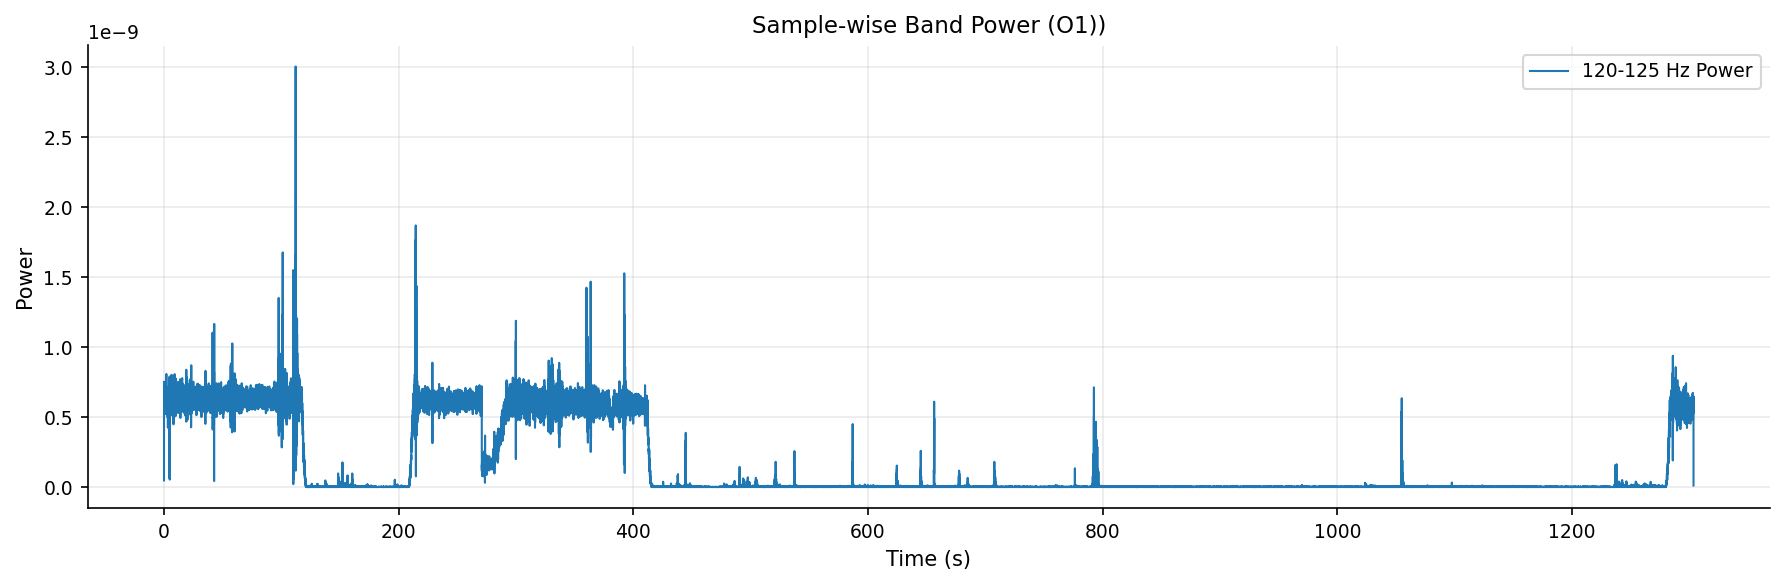

In [21]:
# compute eeg power 
eeg_power_pat2, time_axis_pat2 = compute_samplewise_eeg_power(eeg_raw_pat2, 120, 125, channel='O1', plot=True)

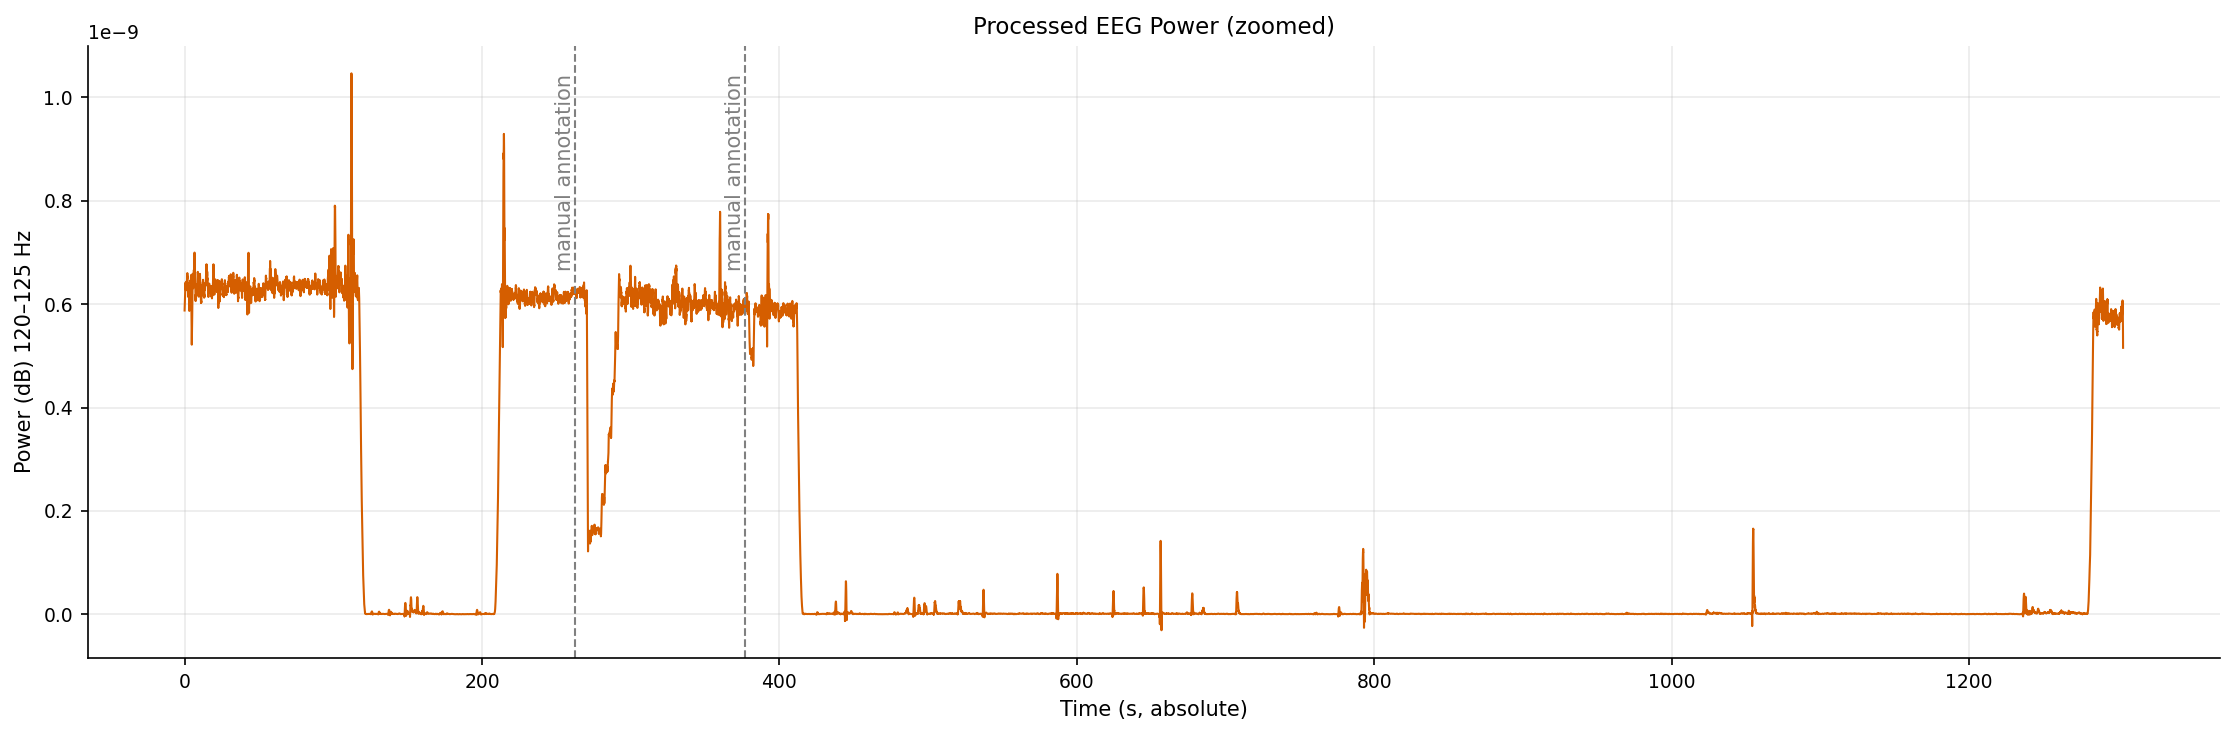

In [22]:
# given
t = time_axis_pat2            # long absolute time vector
p = eeg_power_pat2               # same length

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(t, p, color='#D55E00')

for s in (sync1_sec, sync2_sec):
    ax.axvline(s, color='grey', ls='--')
    ax.text(s, ax.get_ylim()[1]*0.95, "manual annotation",
            color="grey", rotation=90, va="top", ha="right")

ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{x:.0f}"))
ax.set_xlabel("Time (s, absolute)")
ax.set_ylabel("Power (dB) 120–125 Hz")
ax.set_title("Processed EEG Power (zoomed)")

# plt.savefig(f"notebooks/outputs/plots/fig3_validation_manual_sync.pdf")

plt.show()

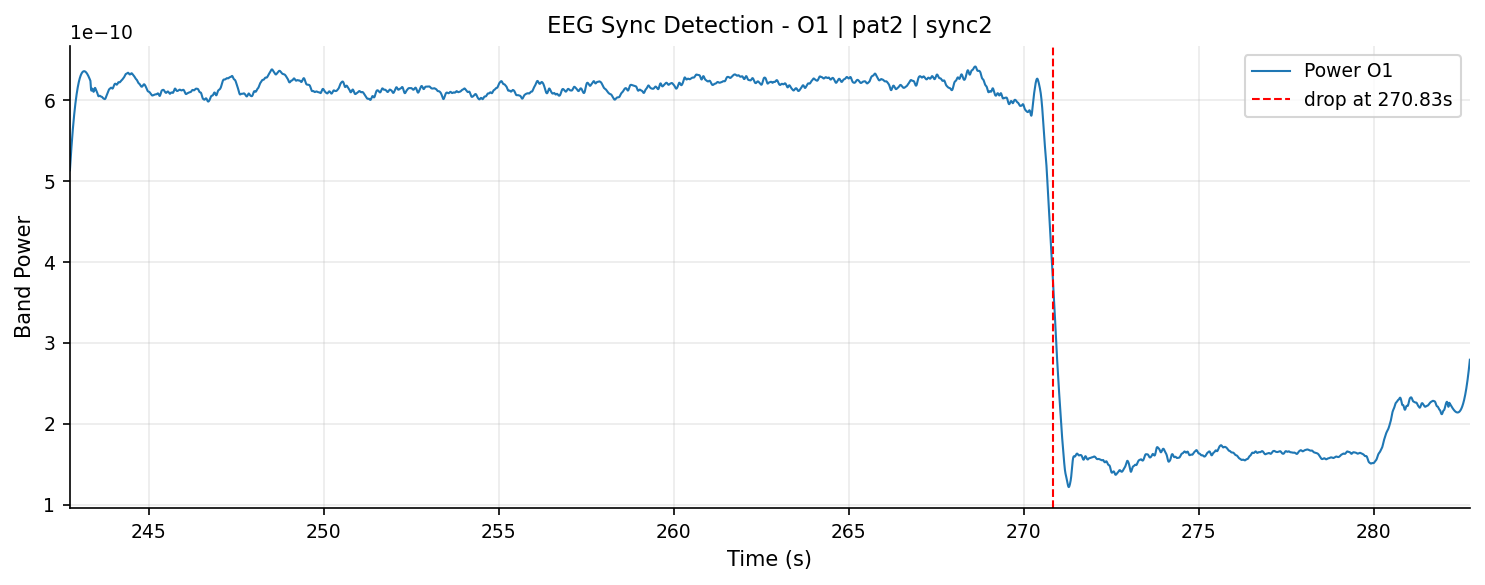

Sync 1 detected at 270.828125s or 69332 samples


In [23]:
# use detect_eeg_sync_artifact to find the sync events
best_channel, eeg_sync_idx, eeg_sync_s, best_result, power = detect_eeg_sync_artifact(eeg_raw_pat2, freq_low=120, freq_high=125, time_range=(sync1_sec-20, sync1_sec+20), channel_list=['O1'], plot=True, save_dir=None, sub_id='pat2', block='sync2')
print(f'Sync 1 detected at {eeg_sync_s}s or {eeg_sync_idx} samples')

In [24]:
# plot the same with plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=time_axis_pat2, y=eeg_power_pat2, mode='lines'))
fig.show()


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

-> -0.5 mA nicely visible, -0.1 could be mistaken as noise...

Check tapping

In [ ]:
eeg_power_pat2_Cz, time_axis_pat2_Cz = compute_samplewise_eeg_power(eeg_raw_pat2, 1, 100, channel='Cz', plot=False)

In [ ]:
# plot eeg_power_cz with plotly around the tap_sec
tap_sec = 333.97
tap_idx = int(tap_sec * eeg_raw_pat2.info['sfreq'])
time_axis_Cz_tap = time_axis_pat2_Cz[tap_idx-5000:tap_idx+5000]
eeg_power_Cz_tap = eeg_power_pat2_Cz[tap_idx-5000:tap_idx+5000]


fig = go.Figure()
fig.add_trace(go.Scatter(x=time_axis_Cz_tap, y=eeg_power_Cz_tap, mode='lines'))
# add vertical line at tap_sec
fig.add_vline(x=tap_sec, line_dash="dash", line_color="grey")
# add text at tap_sec 90 degrees rotated
fig.add_annotation(x=tap_sec, y=eeg_power_Cz_tap.max(), text=f"Cz electrode tapping", showarrow=False)
fig.show()

# Next: Tapping in DBS?
- extract first sync dbs artifact via algorithm
- align dbs and EEG data with at the first detected sync artifact and resample to 250Hz
- visualize the aligned signals to see if the taps align



In [ ]:
# read json file
json_file = Path(r"/Volumes/green_groups_re_public/RELab/Data_confidential/StimuLOOP_Neurofeedback/eeg_dbs_sync_epi/Report_Json_Session_Report_20250714T125042_pat1.json")
json_data = data_loader.open_json_file(json_file)
dbs_data = data_loader.read_time_domain_data(json_data, 0)
dbs_fs = dbs_data["SampleRateInHz"][0]

---
Successfully read DBS recording 0 with sampling frequency 250 Hz
...length of dbs signal in seconds: 85.248
...length of dbs signal in samples: 21312


In [ ]:
dbs_signal = dbs_data["TimeDomainData"].values

---
Plot saved to outputs/plots/20250911_094947_syncDBS_None_None.png


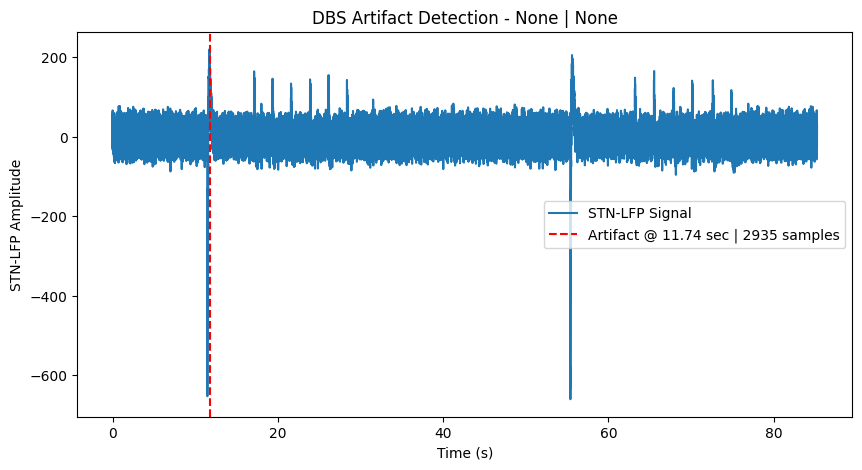

In [ ]:
# extract first sync dbs artifact via algorithm
dbs_sync_idx, dbs_sync_s = detect_dbs_sync_artifact(dbs_signal, dbs_fs)

In [ ]:
# print dbs_sync_s
print(f"DBS sync at {dbs_sync_s} seconds")
print(f"DBS sync at {dbs_sync_idx} samples")

DBS sync at 11.74 seconds
DBS sync at 2935 samples


In [ ]:
# Compute time axis
dbs_time_axis = np.arange(len(dbs_signal)) / dbs_fs

# Create figure with plotly to zoom in
fig = go.Figure()

# Plot DBS signal
fig.add_trace(go.Scatter(
    x=dbs_time_axis,
    y=dbs_signal,
    mode="lines",
    name="DBS Signal"
))

# Add vertical marker at peak
fig.add_trace(go.Scatter(
    x=[dbs_sync_s],
    y=[dbs_signal[dbs_sync_idx]],
    mode="markers+text",
    text=["Peak"],
    textposition="top center",
    marker=dict(color="red", size=10, symbol="x"),
    name="DBS Peak"
))

# Update layout
fig.update_layout(
    title=f"DBS Signal",
    xaxis_title="Time (s)",
    yaxis_title="Amplitude",
    template="plotly_white",
    hovermode="x unified"
)

fig.show()



Compute stn-lfp power to check for tapping


In [ ]:
# filter dbs signal
from scipy.signal import butter, filtfilt

# Parameters
freq_low, freq_high = 1, 100
order = 4  # typical

# Normalize frequencies
nyq = dbs_fs / 2.0
b, a = butter(order, [freq_low/nyq, freq_high/nyq], btype='band')

# Zero-phase filtering
dbs_signal_filtered = filtfilt(b, a, dbs_signal)

dbs_signal_filtered = dbs_signal_filtered.squeeze()
# Hilbert transform to get analytic signal
analytic_signal = hilbert(dbs_signal_filtered)
dbs_power_trace = np.abs(analytic_signal) ** 2

# Time axis
dbs_time_axis = np.arange(len(dbs_power_trace)) / dbs_fs

# plot the same with plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=dbs_time_axis, y=dbs_power_trace, mode='lines'))

fig.show()  


Cannot detect the taps. Will try to synchronize the signals anyways to check for tap-based artifacts

In [ ]:
from scipy.signal import resample_poly

start_eeg = 69333
start_dbs = 2935
tap_idx = 33397
eeg_fs = 2000


# ---- Downsample EEG: 2000 -> 250 Hz (factor 8) ----
# Use polyphase filtering for clean decimation
eeg_ds = resample_poly(eeg_power_pat2, up=1, down=eeg_fs // dbs_fs)

# Map EEG start index to 250 Hz domain (not always an integer sample -> round)
start_eeg_ds = int(round(start_eeg * (dbs_fs / eeg_fs)))  # ≈ 8667 for given numbers
tap_idx_ds = int(round(tap_idx * (dbs_fs / eeg_fs)))

# ---- Cut both signals so t=0 corresponds to their start samples ----
eeg_cut = eeg_ds[start_eeg_ds:]
dbs_cut = dbs_signal[start_dbs:]

# Optionally trim to equal length for overlay
N = min(len(eeg_cut), len(dbs_cut))
eeg_cut = eeg_cut[:N]
dbs_cut = dbs_cut[:N]

# ---- Optional: scale EEG amplitude for visual comparability ----
# Match standard deviations (robust and simple). Change to 'max' if preferred.
scale = 10 * (np.std(dbs_cut) + 1e-12) / (np.std(eeg_cut) + 1e-12)
eeg_scaled = eeg_cut * scale

# ---- Time axis (both now at 250 Hz, start at 0) ----
t = np.arange(N) / dbs_fs

# ---- Plotly ----
fig = go.Figure()
fig.add_trace(go.Scatter(x=t, y=dbs_cut, mode='lines', name='DBS Power (250 Hz)'))
fig.add_trace(go.Scatter(x=t, y=eeg_scaled, mode='lines', name=f'EEG Power (downsampled + scaled×{scale:.2f})'))

fig.update_layout(
    title="EEG vs DBS: Downsampled to 250 Hz, Start-Aligned at t=0",
    xaxis_title="Time (s)",
    yaxis_title="Amplitude",
    template="plotly_white",
    legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='left', x=0)
)

# add a vertical line at tap_idx_ds 
fig.add_vline(x=tap_idx_ds / dbs_fs, line_dash="dash", line_color="grey", name="tap_idx_ds")
# add text at tap_idx_ds
fig.add_annotation(x=tap_idx_ds / dbs_fs, y=eeg_scaled.max(), text=f"sync marker tapping: {tap_idx_ds/dbs_fs} s", showarrow=False)

fig.show()

In [ ]:
tap_idx_ds/250


16.7